# AR-VAE

We consider AR-VAE, a variational autoencoder in which the prior is parameterized by an autoregressive model rather than a standard Gaussian. 

## 1. Setup

In [1]:
#@markdown

!pip -q install datasets pychalk

In [2]:
#@markdown

from dataclasses import dataclass
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image

## 2. Dataset

In [22]:
#@markdown

class CelebAFaces(Dataset):
    """CelebA faces dataset.
    
    Parameters
    ----------
    
    resolution: int - Image resolution.
    
    Example
    -------
    
    >>> dataset = CelebAFaces(resolution=256)
    """
    
    def __init__(self, resolution: int) -> None:
        """Initializes the dataset."""
        
        self.resolution = resolution
        
        # Load the dataset in streaming mode from Hugging Face.
        
        self._dataset = load_dataset(
            path='nielsr/CelebA-faces', 
            split='train', 
            streaming=True,
        ).shuffle()
        
        # Create an iterator for the dataset.
        
        self._dataset_iterator = iter(self._dataset)
        
        # Define a transform to be applied to each example.
        
        self._transform = transforms.Compose([
            transforms.Resize(
                size=(self.resolution, self.resolution),
                interpolation=0,
            ),
            transforms.PILToTensor(),
            transforms.Lambda(lambda x: x / 255.),
        ])
        
        # Get the length of the dataset.
        
        self._length = self._dataset.info.splits['train'].num_examples
        
    def __len__(self) -> int:
        """Returns the length of the dataset."""
        
        return self._length

    def __getitem__(self, index: int) -> torch.Tensor:
        """Returns an example from the dataset."""
        
        example = next(self._dataset_iterator)['image']
        example = self._transform(example)
        
        return example

In [23]:
#@markdown

train_dataset = CelebAFaces(resolution=128)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2)

## 3. Model

In [3]:
#@markdown

@dataclass
class CausalCNNOptions:
    """Causal CNN options."""

    hidden_channels: int
    kernel_size: int
    vocabulary_size: int
    sequence_length: int
    embedding_dimension: int

In [651]:
#@markdown

class CausalCNN(nn.Module):
    """Causal CNN."""
    
    def __init__(self, options: CausalCNNOptions) -> None:
        """Initializes the module."""
        
        super(CausalCNN, self).__init__()
        self.options = options
        
        self.position_embedding = nn.Embedding(num_embeddings=options.sequence_length, embedding_dim=options.embedding_dimension)
        
        self.convolution_1 = nn.Conv1d(in_channels=options.embedding_dimension + options.vocabulary_size, out_channels=options.hidden_channels, kernel_size=options.kernel_size, stride=1, padding=0, dilation=1)
        self.convolution_2 = nn.Conv1d(in_channels=options.hidden_channels, out_channels=options.hidden_channels, kernel_size=options.kernel_size, stride=1, padding=0, dilation=2)
        self.convolution_3 = nn.Conv1d(in_channels=options.hidden_channels, out_channels=options.hidden_channels, kernel_size=options.kernel_size, stride=1, padding=0, dilation=4)
        self.convolution_4 = nn.Conv1d(in_channels=options.hidden_channels, out_channels=options.hidden_channels, kernel_size=options.kernel_size, stride=1, padding=0, dilation=16)
        self.convolution_5 = nn.Conv1d(in_channels=options.hidden_channels, out_channels=options.hidden_channels, kernel_size=options.kernel_size, stride=1, padding=0, dilation=64)
        self.convolution_6 = nn.Conv1d(in_channels=options.hidden_channels, out_channels=options.vocabulary_size, kernel_size=options.kernel_size, stride=1, padding=0, dilation=128)

        self.padding_1 = (self.options.kernel_size, -1)
        self.padding_2 = ((self.options.kernel_size - 1) * 2, 0, 0, 0)
        self.padding_3 = ((self.options.kernel_size - 1) * 4, 0, 0, 0)
        self.padding_4 = ((self.options.kernel_size - 1) * 16, 0, 0, 0)
        self.padding_5 = ((self.options.kernel_size - 1) * 64, 0, 0, 0)
        self.padding_6 = ((self.options.kernel_size - 1) * 128, 0, 0, 0)
        
    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        
        # Embeddings.
 
        tokens = tokens.to(int).cuda()
        positions = torch.arange(self.options.sequence_length).to(int).cuda()
        positions = positions.view(1, -1).repeat(tokens.size(0), 1)
        
        token_embeddings = F.one_hot(tokens, num_classes=self.options.vocabulary_size)
        position_embeddings = self.position_embedding(positions)
        
        x = torch.cat((token_embeddings, position_embeddings), dim=-1)
        
        # CNN.
        
        x = x.transpose(-2, -1)
        x = F.leaky_relu(self.convolution_1(F.pad(x, self.padding_1)))
        x = F.leaky_relu(self.convolution_2(F.pad(x, self.padding_2))) #+ x
        x = F.leaky_relu(self.convolution_3(F.pad(x, self.padding_3))) #+ x
        x = F.leaky_relu(self.convolution_4(F.pad(x, self.padding_4))) #+ x
        x = F.leaky_relu(self.convolution_5(F.pad(x, self.padding_5))) #+ x
        x = self.convolution_6(F.pad(x, self.padding_6))
        x = x.transpose(-2, -1)
        
        # Logits.
        
        x = F.log_softmax(x, dim=-1)
    
        return x

In [716]:
sum([p.numel() for p in model.parameters()])

27458

In [652]:
#@markdown

from torchvision.datasets import MNIST

mnist_dataset = MNIST(root='.', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.round()),
]))

mnist_dataloader = DataLoader(dataset=mnist_dataset, shuffle=True, batch_size=128)

In [792]:
#@markdown

#model = CausalCNN(CausalCNNOptions(hidden_channels=32, kernel_size=6, sequence_length=28*28, vocabulary_size=2, embedding_dimension=2)).cuda()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [793]:
epochs = 5
model.train()

for epoch in range(epochs):
    for batch_index, (y, _) in enumerate(mnist_dataloader):
        if (len(y) != 128):
            continue
            
        y = y.to(int).cuda().view(128, 28*28)
        yp = model(y)

        optimizer.zero_grad()
        loss = criterion(yp.view(-1, 2), y.flatten())
        loss.backward()
        optimizer.step()
        
        if (batch_index % 100) == 0:
            print(f'epoch {epoch + 1}/{epochs}, batch {batch_index + 1}/{len(mnist_dataset)//128} - {loss.detach().item()}')

epoch 1/5, batch 1/468 - 0.07550138235092163
epoch 1/5, batch 101/468 - 0.07674923539161682
epoch 1/5, batch 201/468 - 0.07591504603624344
epoch 1/5, batch 301/468 - 0.07670727372169495
epoch 1/5, batch 401/468 - 0.07553686946630478
epoch 2/5, batch 1/468 - 0.07472698390483856
epoch 2/5, batch 101/468 - 0.07491572201251984
epoch 2/5, batch 201/468 - 0.07731043547391891
epoch 2/5, batch 301/468 - 0.07579892873764038
epoch 2/5, batch 401/468 - 0.07346445322036743
epoch 3/5, batch 1/468 - 0.07726892828941345
epoch 3/5, batch 101/468 - 0.07493554800748825
epoch 3/5, batch 201/468 - 0.07357580214738846
epoch 3/5, batch 301/468 - 0.07335098087787628
epoch 3/5, batch 401/468 - 0.07823026180267334
epoch 4/5, batch 1/468 - 0.07491743564605713
epoch 4/5, batch 101/468 - 0.07583694905042648
epoch 4/5, batch 201/468 - 0.07581239193677902
epoch 4/5, batch 301/468 - 0.07405684143304825
epoch 4/5, batch 401/468 - 0.07885908335447311
epoch 5/5, batch 1/468 - 0.0764915943145752
epoch 5/5, batch 101/468

In [909]:
import random

def sample_greedy(model: CausalCNN, prefix: torch.Tensor = None) -> torch.Tensor:
    
    model.eval()
        
    sequence_length = model.options.sequence_length
    offset = 0
    sample = torch.zeros(sequence_length).cuda()
    
    if prefix is not None:
        offset = prefix.size(0)
        sample[: offset] = prefix
    
    for i in range(offset, sequence_length):
        logits = model(sample.view(1, sequence_length))[0, i].detach()
        probability = torch.exp(logits)[1]
        value = random.random() < probability
        sample[i] = value
    
    model.train()
    
    return sample

In [921]:
def show_prefix(model, prefix):
    
    sequence_length = model.options.sequence_length
    offset = prefix.size(0)

    sample = torch.zeros(sequence_length).cuda()
    sample[: offset] = prefix
    
    return sample

In [1126]:
def show_distribution(model, prefix):
    model.eval()
        
    sequence_length = model.options.sequence_length
    offset = 0
    sample = torch.zeros(sequence_length).cuda()
    
    if prefix is not None:
        offset = prefix.size(0)
        sample[: offset] = prefix
    
    logits = model(sample.view(1, sequence_length)).detach()
    probability = torch.exp(logits)[0,:,1]
    
    return probability

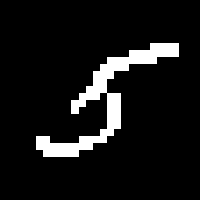

In [1192]:
example = mnist_dataset[35][0]

transforms.ToPILImage()(example).resize((200, 200), 0)

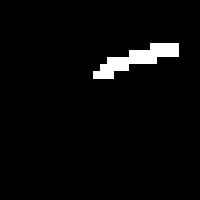

In [1193]:
prefix = example.flatten()[: 300]

transforms.ToPILImage()(show_prefix(model, prefix).view(28, 28)).resize((200, 200), 0)

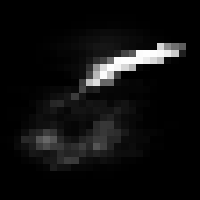

In [1194]:
transforms.ToPILImage()(show_distribution(model, prefix).view(28, 28)).resize((200,200),0)

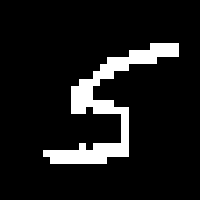

In [1195]:
transforms.ToPILImage()(sample_greedy(model, prefix=prefix).view(28, 28)).resize((200, 200), 0)

In [1093]:
torch.save(model, 'causal-cnn-mnist-2.pt')

In [726]:
#@markdown

from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F


class CausalCNN
    


class VariationalAutoencoder(nn.Module):
  """A convolutional variational autoencoder."""

  def __init__(self, in_channels: int = 3) -> None:
    super().__init__()

    self.encoder = nn.Sequential(

        nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.GroupNorm(num_channels=64, num_groups=8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.GroupNorm(num_channels=64, num_groups=8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.GroupNorm(num_channels=64, num_groups=8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.GroupNorm(num_channels=64, num_groups=8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.GroupNorm(num_channels=64, num_groups=8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.GroupNorm(num_channels=64, num_groups=8),
        nn.LeakyReLU(0.2),

        nn.Flatten(),
    )

    latent_size = 256
    flatten_size = 64 * 2 * 2
    unflatten_size = (64, 2, 2)

    self.decoder = nn.Sequential(

        nn.Linear(latent_size, flatten_size),
        nn.Unflatten(-1, unflatten_size),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=64, out_channels=in_channels, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=in_channels),
        nn.Sigmoid(),
    )

    self.encoder_mean = nn.Linear(flatten_size, latent_size)
    self.encoder_log_variance = nn.Linear(flatten_size, latent_size)
    
    
  def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """Maps observations to Gaussian distributions over latents."""

    x = self.encoder(x)
    z_mean = self.encoder_mean(x)
    z_log_variance = self.encoder_log_variance(x)

    return z_mean, z_log_variance

  def decode(self, z: torch.Tensor) -> torch.Tensor:
    """Maps latents to Gaussian distributions over observations."""

    x = self.decoder(z)

    return x

  def sample(
      self,
      z_mean: torch.Tensor,
      z_log_variance: torch.Tensor,
  ) -> torch.Tensor:
    """Samples from Gaussian distributions over latents."""

    epsilon = torch.randn_like(z_mean)
    z_standard_deviation = torch.exp(0.5 * z_log_variance)
    z = z_mean + z_standard_deviation * epsilon

    return z

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """Forward pass."""

    z_mean, z_log_variance = self.encode(x)
    z = self.sample(z_mean, z_log_variance)
    x = self.decode(z)

    return x, z_mean, z_log_variance

SyntaxError: invalid syntax (1031551726.py, line 10)

In [8]:
transforms.ToPILImage()

ToPILImage()

In [97]:
mode = VariationalAutoencoder()

In [98]:
mode.cuda().encoder(x).shape

torch.Size([128, 64, 2, 2])

In [82]:
#@markdown

def ELBOLoss(kl_weight: float = 1.0):
  """Computes the ELBO loss."""

  def loss(
      xp: torch.Tensor,
      x: torch.Tensor,
      z_mean: torch.Tensor,
      z_log_variance: torch.Tensor,
  ) -> torch.Tensor:

    reconstruction_loss = F.binary_cross_entropy(xp, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + z_log_variance - z_mean.pow(2) - z_log_variance.exp())

    return reconstruction_loss + kl_weight * kl_loss

  return loss

In [83]:
def generate(latent_dimension: int, batch_size: int, scale: float = 0.2) -> torch.Tensor:

    z = scale * torch.randn(batch_size, latent_dimension).cuda()
    x = model.decode(z).detach()

    return x

In [84]:
#@markdown

batch_size = 128
image_channels = 3
image_width = 128
image_height = 128

model = VariationalAutoencoder(in_channels=image_channels).cuda()
criterion = ELBOLoss(kl_weight=50.)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 3
batches = len(train_dataset) // batch_size

In [105]:
#@markdown

import chalk
from torchvision.utils import save_image

model.train()

previous_loss = 1.
current_loss = 1.
losses = []
loss_normalizer = image_width * image_height * image_channels * batch_size

for epoch in range(epochs):
    
    for i, batch in enumerate(train_dataloader):
        x = batch.cuda()
        xp, z_mean, z_log_variance = model(x)

        optimizer.zero_grad()
        loss = criterion(xp, x, z_mean, z_log_variance)
        loss.backward()
        optimizer.step()

        losses.append(loss.item() / batch_size)

        if (i + 1) % 20 == 0:

            current_loss = sum(losses) / len(losses)
            percent_change = ((current_loss - previous_loss) / current_loss) * 100
            sign_percent_change = '' if percent_change < 0 else '+'
            change_indicator = f'({sign_percent_change}{percent_change:0.2f}%)'
            change_indicator = chalk.green(change_indicator) if percent_change < 0 else chalk.red(change_indicator)
            loss_indicator = 'loss: ' + chalk.blue(f'{current_loss:0.4f}')
            
            previous_loss = current_loss
            
            print(f'[info] epoch: {epoch}/{epochs}, batch: {i:04d}/{batches}, {loss_indicator} {change_indicator}')
            
            losses.clear()
        
        if (i + 1) % 200 == 0:
            
            model.eval()

            torch.save(model, './model.checkpoint')
            
            save_image(xp[:64], './reconstructions.png')
            save_image(x[:64], './inputs.png')
            save_image(generate(latent_dimension=256, batch_size=64, scale=0.5), 'samples.png')
            
            model.train()

[info] epoch: 0/3, batch: 0019/1582, loss: 27020.8270 (+100.00%)
[info] epoch: 0/3, batch: 0039/1582, loss: 26975.8664 (-0.17%)
[info] epoch: 0/3, batch: 0059/1582, loss: 27024.0349 (+0.18%)
[info] epoch: 0/3, batch: 0079/1582, loss: 27089.3137 (+0.24%)


KeyboardInterrupt: 

In [108]:

save_image(generate(latent_dimension=256, batch_size=64, scale=1), 'samples.png')